# Exploratory Data Analysis of IPAGE Soil Data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Load data
df = pd.read_csv('./2410_iPAGE_SoilData_241029.csv')

# Check first rows
df.head()

,Area,soil group,Land class,knit (surface),pH,SOC (%),Nitrogen N (%),Potassium K (meq/100),Phosphorus P (ug/g),Sulfur S (ug/g),Boron B (ug/g),Zinc Zn (ug/g)
0,Mithpukur,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86
1,Mithpukur,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75
2,Mithpukur,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95
3,Mithpukur,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.0
4,Mithpukur,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Area                   618 non-null    object 
 1   soil group             618 non-null    object 
 2   Land class             618 non-null    object 
 3   knit (surface)         461 non-null    object 
 4   pH                     618 non-null    object 
 5   SOC (%)                618 non-null    float64
 6   Nitrogen N (%)         618 non-null    object 
 7   Potassium K (meq/100)  618 non-null    object 
 8   Phosphorus P (ug/g)    618 non-null    object 
 9   Sulfur S (ug/g)        618 non-null    object 
 10  Boron B (ug/g)         618 non-null    object 
 11  Zinc Zn (ug/g)         618 non-null    object 
dtypes: float64(1), object(11)
memory usage: 58.1+ KB


In [4]:
# Drop null rows
df = df.dropna()

# Check number of entries
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 461 entries, 0 to 520
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Area                   461 non-null    object 
 1   soil group             461 non-null    object 
 2   Land class             461 non-null    object 
 3   knit (surface)         461 non-null    object 
 4   pH                     461 non-null    object 
 5   SOC (%)                461 non-null    float64
 6   Nitrogen N (%)         461 non-null    object 
 7   Potassium K (meq/100)  461 non-null    object 
 8   Phosphorus P (ug/g)    461 non-null    object 
 9   Sulfur S (ug/g)        461 non-null    object 
 10  Boron B (ug/g)         461 non-null    object 
 11  Zinc Zn (ug/g)         461 non-null    object 
dtypes: float64(1), object(11)
memory usage: 46.8+ KB


In [5]:
# Rename columns to be more concise
df.rename(columns={'soil group': 'Soil group',
                   'knit (surface)': 'Soil type',
                   'SOC (%)': 'SOC',
                   'Nitrogen N (%)': 'Nitrogen',
                   'Potassium K (meq/100)': 'Potassium',
                   'Phosphorus P (ug/g)': 'Phosphorus',
                   'Sulfur S (ug/g)': 'Sulfur',
                   'Boron B (ug/g)': 'Boron',
                   'Zinc Zn (ug/g)': 'Zinc'},
          inplace=True)

# Label numerical columns
numerical_cols = ['pH', 'SOC', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Boron', 'Zinc']

# Change dtypes to float64 for numerical columns
for column in numerical_cols:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Drop nullsw again because of numeric conversion issues
df = df.dropna()

# Check new number of entries
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 454 entries, 0 to 520
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        454 non-null    object 
 1   Soil group  454 non-null    object 
 2   Land class  454 non-null    object 
 3   Soil type   454 non-null    object 
 4   pH          454 non-null    float64
 5   SOC         454 non-null    float64
 6   Nitrogen    454 non-null    float64
 7   Potassium   454 non-null    float64
 8   Phosphorus  454 non-null    float64
 9   Sulfur      454 non-null    float64
 10  Boron       454 non-null    float64
 11  Zinc        454 non-null    float64
dtypes: float64(8), object(4)
memory usage: 46.1+ KB


In [6]:
# Split data before any processing
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)

In [7]:
# Create map for knit (surface)
soil_mapping = {
    'loam': {'sand': 40,'silt': 40,'clay': 20},
    'Clay loam ': {'sand': 33,'silt': 33,'clay': 33},
    'loam clay': {'sand': 33,'silt': 33,'clay': 33},
    'brick': {'sand': 20,'silt': 20,'clay': 60},
    'in the sand': {'sand': 80,'silt': 10,'clay': 10}
}

# Create columns to split soil knit in to % Sand, Silt and Clay
train_data['Sand'] = train_data['Soil type'].map(lambda x: soil_mapping[x]['sand'])
train_data['Silt'] = train_data['Soil type'].map(lambda x: soil_mapping[x]['silt'])
train_data['Clay'] = train_data['Soil type'].map(lambda x: soil_mapping[x]['clay'])

test_data['Sand'] = test_data['Soil type'].map(lambda x: soil_mapping[x]['sand'])
test_data['Silt'] = test_data['Soil type'].map(lambda x: soil_mapping[x]['silt'])
test_data['Clay'] = test_data['Soil type'].map(lambda x: soil_mapping[x]['clay'])

train_data.head()

,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
52,Mithpukur,Sahapur,Medium high land,loam,5.2,1.51,0.08,0.08,5.0,1.8,0.28,0.68,40,40,20
75,Mithpukur,Pirgacha,high ground,loam,5.3,2.18,0.10,0.28,162.8,14.8,0.44,2.06,40,40,20
26,Mithpukur,Noadda,high ground,Clay loam,5.0,2.01,0.12,0.13,38.0,5.1,0.32,1.29,33,33,33
45,Mithpukur,the moon,Medium high land,Clay loam,5.2,1.45,0.08,0.06,10.4,8.8,0.40,0.43,33,33,33
123,Mithpukur,Gangachara,high ground,loam,5.0,2.21,0.13,0.09,47.1,38.2,0.48,1.23,40,40,20


In [8]:
# Quick check on variance of a target variable grouped by Soil group
grouped = df.groupby('Soil group')['SOC'].mean()

df['SOC mean by Soil group'] = df['Soil group'].map(grouped)

print(grouped)

Soil group
Alluvial soil of Teesta    1.167037
Berries                    1.509095
Berries                    1.614000
Chilmari                   1.860000
Gangachara                 1.972199
Imadpur                    2.097143
Imadpur                    2.870000
Kachna                     2.850000
Kachna                     2.790000
Kaunia                     2.717917
Khilgaon                   2.647500
Noadda                     1.720750
Palashbari                 1.600851
Pirgacha                   2.094000
Saghata                    1.195000
Sahapur                    1.936250
Teesta sandy soil          0.960000
The militants              4.720000
The militants              3.080000
belab                      1.390000
the moon                   1.811765
the pen                    2.380000
Name: SOC, dtype: float64


In [9]:
# Check for entries with extra space at the end of the entry
trailing_spaces = df['Soil group'].str.endswith(' ')

print("Rows with trailing spaces:\n", df[trailing_spaces])

Rows with trailing spaces:
                Area      Soil group        Land class   Soil type   pH   SOC  \
64        Mithpukur        the pen   Medium high land  Clay loam   5.0  2.38   
206       Mithpukur        Imadpur    Medium low land        loam  5.7  2.87   
210       Mithpukur         Kachna   Medium high land  Clay loam   6.1  2.37   
211       Mithpukur         Kachna    Medium low land  Clay loam   5.2  3.66   
212       Mithpukur         Kachna    Medium low land  Clay loam   5.4  2.34   
427  Kaunia upazila        Berries        high ground        loam  4.7  0.96   
428  Kaunia upazila        Berries        high ground        loam  5.1  1.72   
434  Kaunia upazila        Berries        high ground        loam  5.1  1.72   
435  Kaunia upazila        Berries        high ground        loam  5.8  1.92   
441  Kaunia upazila        Berries        high ground        loam  5.3  1.72   
442  Kaunia upazila        Berries        high ground        loam  5.3  1.92   
443  Kaunia 

In [10]:
# Strip off the trailing white space
df['Soil group'] = df['Soil group'].str.strip()

# Check to see that there are no duplicate groups now
print("Unique values after stripping:\n", df['Soil group'].unique())

# Remove group by column
df.drop(columns=['SOC mean by Soil group'], inplace=True)

Unique values after stripping:
 ['belab' 'Noadda' 'Sahapur' 'the moon' 'the pen' 'Khilgaon' 'Pirgacha'
 'Palashbari' 'Berries' 'Gangachara' 'Kaunia' 'Imadpur'
 'Alluvial soil of Teesta' 'Teesta sandy soil' 'Kachna' 'The militants'
 'Chilmari' 'Saghata']


In [11]:
# Function for target mean encoding the soil groups for each target variable
def target_mean_encoding(df_train, df_test, categorical_column, target_column):
    # Calculate mean encoding for each category in the training set
    category_means = df_train.groupby(categorical_column)[target_column].mean()
    global_mean = df_train[target_column].mean()
    
    # Add encoded column to training set
    train_encoded_col = f'{target_column} mean by {categorical_column}'
    df_train[train_encoded_col] = df_train[categorical_column].map(category_means)
    df_train[train_encoded_col].fillna(global_mean, inplace=True)
    
    # Add encoded column to test set
    test_encoded_col = f'{target_column} mean by {categorical_column}'
    df_test[test_encoded_col] = df_test[categorical_column].map(category_means)
    df_test[test_encoded_col].fillna(global_mean, inplace=True)
    
    return df_train, df_test

# Apply the function to target variables
for target in ['SOC', 'Boron', 'Zinc']:
    train_data, test_data = target_mean_encoding(train_data, test_data, 'Soil group', target)

,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay,SOC mean by Soil group,Boron mean by Soil group,Zinc mean by Soil group
52,Mithpukur,Sahapur,Medium high land,loam,5.2,1.51,0.08,0.08,5.0,1.8,0.28,0.68,40,40,20,1.906667,0.346667,0.702500
75,Mithpukur,Pirgacha,high ground,loam,5.3,2.18,0.10,0.28,162.8,14.8,0.44,2.06,40,40,20,1.315263,0.431053,1.798947
26,Mithpukur,Noadda,high ground,Clay loam,5.0,2.01,0.12,0.13,38.0,5.1,0.32,1.29,33,33,33,1.724455,0.340000,1.032727
45,Mithpukur,the moon,Medium high land,Clay loam,5.2,1.45,0.08,0.06,10.4,8.8,0.40,0.43,33,33,33,1.785333,0.334667,0.674667
123,Mithpukur,Gangachara,high ground,loam,5.0,2.21,0.13,0.09,47.1,38.2,0.48,1.23,40,40,20,1.953434,0.311724,0.887793


In [15]:
# Make list of columns to be OneHot encoded
one_hot_cols = ['Area', 'Land class', 'Soil type']

# OneHotEncoder setup
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_data = encoder.fit(train_data[one_hot_cols])

# Transform training and test data
train_encoded = encoder.transform(train_data[one_hot_cols])
test_encoded = encoder.transform(test_data[one_hot_cols])

# Convert the encoded arrays to DataFrames
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(one_hot_cols))
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(one_hot_cols))

# Reset indices to align during concatenation
train_encoded_df.index = train_data.index
test_encoded_df.index = test_data.index

# Combine the encoded data with the original datasets
train_data = pd.concat([train_data, train_encoded_df], axis=1)
test_data = pd.concat([test_data, test_encoded_df], axis=1)

#print("Encoded Training Data:\n", train_data.head())
#print("Encoded Test Data:\n", test_data.head())

Encoded Training Data:
           Area  Soil group        Land class   Soil type   pH   SOC  Nitrogen  \
52   Mithpukur     Sahapur  Medium high land        loam  5.2  1.51      0.08   
75   Mithpukur    Pirgacha       high ground        loam  5.3  2.18      0.10   
26   Mithpukur      Noadda       high ground  Clay loam   5.0  2.01      0.12   
45   Mithpukur    the moon  Medium high land  Clay loam   5.2  1.45      0.08   
123  Mithpukur  Gangachara       high ground        loam  5.0  2.21      0.13   

     Potassium  Phosphorus  Sulfur  ...  Area_Mithpukur  Area_Pirgacha   \
52        0.08         5.0     1.8  ...             1.0             0.0   
75        0.28       162.8    14.8  ...             1.0             0.0   
26        0.13        38.0     5.1  ...             1.0             0.0   
45        0.06        10.4     8.8  ...             1.0             0.0   
123       0.09        47.1    38.2  ...             1.0             0.0   

     Land class_Medium high land  Land

In [16]:
# Create list of numerical columns to be scaled
numerical_cols = ['pH', 'SOC', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Boron', 'Zinc', 'Sand', 'Silt', 'Clay']

# Scale data before engineering numerical features
scaler = StandardScaler()
scaled_data = scaler.fit(train_data[numerical_cols])

# Create copy before further modifications
scaled_train_data = train_data.copy()
scaled_test_data = test_data.copy()

# Transform training and test data for numerical columns only
scaled_train_data[numerical_cols] = scaler.transform(train_data[numerical_cols])
scaled_test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

#print("Scaled Training Data:\n", scaled_train_data.head())
#print("Scaled Test Data:\n", scaled_test_data.head())

Scaled Training Data:
           Area  Soil group        Land class   Soil type        pH       SOC  \
52   Mithpukur     Sahapur  Medium high land        loam  0.078029 -0.515140   
75   Mithpukur    Pirgacha       high ground        loam  0.329354  0.415070   
26   Mithpukur      Noadda       high ground  Clay loam  -0.424622  0.179047   
45   Mithpukur    the moon  Medium high land  Clay loam   0.078029 -0.598443   
123  Mithpukur  Gangachara       high ground        loam -0.424622  0.456722   

     Nitrogen  Potassium  Phosphorus    Sulfur  ...  Area_Mithpukur  \
52  -0.083661  -0.092409   -0.622673 -1.168403  ...             1.0   
75  -0.053249  -0.037300    3.772000  0.007948  ...             1.0   
26  -0.022838  -0.078631    0.296365 -0.869791  ...             1.0   
45  -0.083661  -0.097919   -0.472285 -0.534984  ...             1.0   
123 -0.007632  -0.089653    0.549797  2.125379  ...             1.0   

     Area_Pirgacha   Land class_Medium high land  Land class_Medium l

In [29]:
# Removing any values more than 3 standard deviations from the mean

# Create mask to identify rows to remove
mask_train = (scaled_train_data[numerical_cols] < -3.0) | (scaled_train_data[numerical_cols] > 3.0)
mask_test = (scaled_test_data[numerical_cols] < -3.0) | (scaled_test_data[numerical_cols] > 3.0)

# Find rows with outliers
outliers_train = mask_train.any(axis=1)
outliers_test = mask_test.any(axis=1)

# Filter outliers
scaled_train_data = scaled_train_data[~outliers_train].copy()
scaled_test_data = scaled_test_data[~outliers_test].copy()

In [27]:
# Engineered features with scaled data
scaled_train_data['Clay * pH'] = scaled_train_data['Clay'] * scaled_train_data['pH'] / 2
scaled_train_data['Clay * Nitrogen'] = scaled_train_data['Clay'] * scaled_train_data['Nitrogen'] /2
scaled_train_data['Phosphorus * Nitrogen'] = scaled_train_data['Phosphorus'] * scaled_train_data['Nitrogen'] /2

scaled_test_data['Clay * pH'] = scaled_test_data['Clay'] * scaled_test_data['pH'] / 2
scaled_test_data['Clay * Nitrogen'] = scaled_test_data['Clay'] * scaled_test_data['Nitrogen'] /2
scaled_test_data['Phosphorus * Nitrogen'] = scaled_test_data['Phosphorus'] * scaled_test_data['Nitrogen'] /2

In [30]:
# Categorical columns to drop before PCA
cat_cols = ['Area', 'Soil group', 'Land class', 'Soil type']

# Drop object type columns
pca_train_data = scaled_train_data.drop(columns=cat_cols).copy()
pca_test_data = scaled_test_data.drop(columns=cat_cols).copy()

In [32]:
# Initialize PCA and fit to training data
pca = PCA(n_components=0.9) 
pca_data = pca.fit(pca_train_data)

# Transform both training and test data
train_pca = pca.transform(pca_train_data)
test_pca = pca.transform(pca_test_data)

# Analyze explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Components:", explained_variance)

# Number of components retained
n_components = pca.n_components_
print("Number of Components Retained:", n_components)

Explained Variance by Components: [0.28598654 0.15443734 0.14506496 0.12380261 0.07203029 0.05380485
 0.04814564 0.03144442]
Number of Components Retained: 8


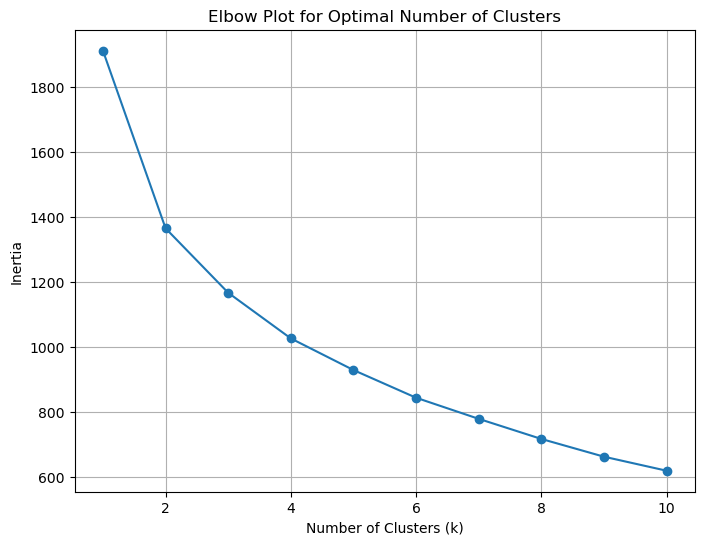

In [38]:
# Determine optimal number of clusters for K means
inertia = []
k_values = range(1,11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(train_pca)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Plot
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

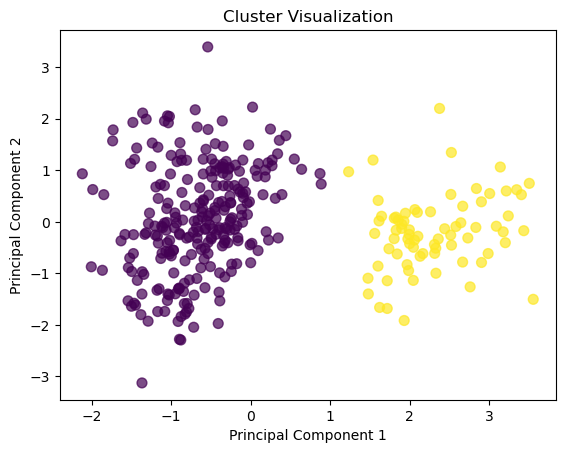

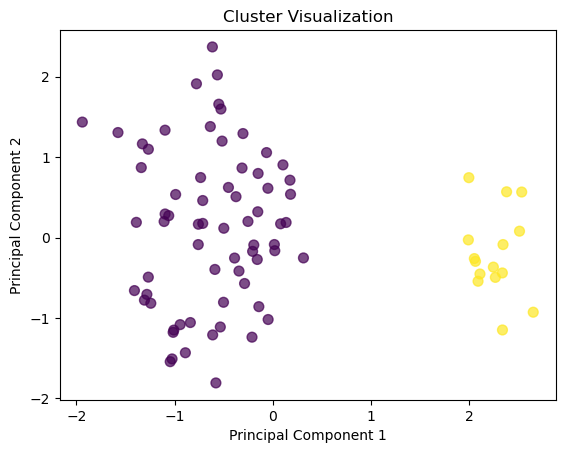

In [47]:
# Fit k means on training data
kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
kmeans.fit(train_pca)

# Predict clusters for training and test set
train_clusters = kmeans.predict(train_pca)
test_clusters = kmeans.predict(test_pca)

# Plot clusters on top 2 principal components
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_clusters, cmap='viridis', s=50, alpha=0.7)
plt.title("Cluster Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

plt.scatter(test_pca[:, 0], test_pca[:, 1], c=test_clusters, cmap='viridis', s=50, alpha=0.7)
plt.title("Cluster Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [48]:
# Combine clusters back in with scaled data
scaled_train_data['Cluster'] = train_clusters
scaled_test_data['Cluster'] = test_clusters

#print(scaled_train_data.head())
#print(scaled_test_data.head())

          Area  Soil group        Land class   Soil type        pH       SOC  \
52   Mithpukur     Sahapur  Medium high land        loam  0.078029 -0.515140   
26   Mithpukur      Noadda       high ground  Clay loam  -0.424622  0.179047   
45   Mithpukur    the moon  Medium high land  Clay loam   0.078029 -0.598443   
123  Mithpukur  Gangachara       high ground        loam -0.424622  0.456722   
162  Mithpukur  Gangachara  Medium high land        loam  0.078029 -0.265233   

     Nitrogen  Potassium  Phosphorus    Sulfur  ...  Land class_high ground  \
52  -0.083661  -0.092409   -0.622673 -1.168403  ...                     0.0   
26  -0.022838  -0.078631    0.296365 -0.869791  ...                     1.0   
45  -0.083661  -0.097919   -0.472285 -0.534984  ...                     0.0   
123 -0.007632  -0.089653    0.549797  2.125379  ...                     1.0   
162 -0.053249  -0.056588   -0.232778  0.188925  ...                     0.0   

     Soil type_Clay loam   Soil type_brick  

In [49]:
# Export to csv for EDA and model training

scaled_train_data.to_csv('scaled_train_data.csv', index=False)
scaled_test_data.to_csv('scaled_test_data.csv', index=False)